In [0]:
!pip install -U -q PyDrive

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from statsmodels.tsa.stattools import adfuller

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import files

%matplotlib inline

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

In [0]:
id = "1Yv6HFnj04nb40Piw4zSzILg1spOBIoPs"


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile("source_stock_data.pkl")  

sd_source = pd.read_pickle("source_stock_data.pkl")
sd_source.head()

Attributes           Adj Close       Close        High         Low  \
Date       Symbols                                                   
2014-01-02 A         38.093895   40.207439   40.844063   40.164520   
           AAL       24.228468   25.360001   25.820000   25.059999   
           AAP      108.756790  109.739998  111.879997  109.290001   
           AAPL      66.964325   79.018570   79.575714   78.860001   
           ABBV      42.494091   51.980000   52.330002   51.520000   

Attributes                Open      Volume  
Date       Symbols                          
2014-01-02 A         40.844063   2678800.0  
           AAL       25.070000   8997900.0  
           AAP      110.360001    542700.0  
           AAPL      79.382858  58671200.0  
           ABBV      52.119999   4569100.0

In [0]:
sd_source['Return10'] = sd_source.groupby(level=['Symbols'])['Adj Close'].pct_change(10)
sd_source['F_return10'] = sd_source.groupby(level=['Symbols'])['Return10'].shift(-10)
sd_source = sd_source.dropna()

In [0]:
sd_source.loc[pd.IndexSlice[:, 'AWK'], ['Adj Close', 'Return10', 'F_return10']]

In [0]:
class FractDiff:
    def __init__(self, fd_steps=11, fd_thres=0.05):
        self._fd_steps = fd_steps
        self._fd_thres = fd_thres
        self._fd_d = {}
        
    def fd_transform(self, ds, fd_columns):
        for col in fd_columns:
            print(col)
            for eq in ds.index.levels[1]:
                ts = ds.xs(eq, level=1).loc[:, [col]]
                if ts.shape[0] == 0:
                    continue
                ts_d, d = self._optimal_diff(ts)
                self._fd_d[(eq, col)] = d
                ds.loc[[(tsi, eq) for tsi in ts_d.index], col+'_fd'] = ts_d.values
        return ds
    
    def _get_weights(self, d, size):
        # thres>0 drops insignificant weights
        w = [1.]
        for k in range(1, size):
            w_ = -w[-1] / k * (d - k + 1)
            w.append(w_)
        w = np.array(w[::-1]).reshape(-1, 1)
        return w
    
    def _frac_diff(self, series, d):
        #1) Compute weights for the longest series
        w = self._get_weights(d, series.shape[0])
        #2) Determine initial calcs to be skipped based on weight-loss threshold
        w_ = np.cumsum(abs(w))
        w_ /= w_[-1]
        skip = w_[w_ > self._fd_thres].shape[0]
        #3) Apply weights to values
        df = {}
        name = series.columns[0]
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]): 
                continue # exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):, :].T, seriesF.loc[:loc])[0, 0]
        df[name] = df_.copy(deep=True)
        df = pd.concat(df, axis=1)
        return df
    
    def _optimal_diff(self, df): 
        if df.shape[0] > 50:
            for d in np.linspace(0, 1, self._fd_steps):
                df2 = self._frac_diff(df, d)
                adf2 = adfuller(df2.iloc[:,0], maxlag=1, regression='c', autolag=None)
                if adf2[0] < adf2[4]['5%']:
                    break
            return df2, d
        else:
            return df, 0

In [0]:
#Apply fractional differencing to a list of data fields
fd_columns_target = ['Adj Close']#, 'High', 'Low', 'Open', 'Volume']
fd_columns = [i + '_fd' for i in fd_columns_target]

fd = FractDiff(fd_steps=6)

start = time.time()
data_fd = fd.fd_transform(sd_source, fd_columns_target)
end = time.time()
print((end-start)/60)

Adj Close
33.38884265820185


In [0]:
data_fd.loc[pd.IndexSlice[:, 'AWK'], ['Adj Close', 'Return10', 'F_return10']]

,Attributes,Adj Close,Return10,F_return10
Date,Symbols,,,
2014-01-16,AWK,36.741699,-0.001684,0.032425
2014-01-17,AWK,36.759399,0.001688,0.025626
2014-01-21,AWK,37.051498,0.013559,0.004313
2014-01-22,AWK,37.272766,0.009590,-0.015993
2014-01-23,AWK,37.317032,0.011031,-0.004266
2014-01-24,AWK,37.024940,0.005529,0.017548
2014-01-27,AWK,36.865627,-0.008097,0.023395
2014-01-28,AWK,36.989544,0.004809,0.028880
2014-01-29,AWK,37.140003,0.010841,0.029271


Symbols
COF     [AxesSubplot(0.125,0.570909;0.775x0.309091), A...
DE      [AxesSubplot(0.125,0.570909;0.775x0.309091), A...
NTRS    [AxesSubplot(0.125,0.570909;0.775x0.309091), A...
RHI     [AxesSubplot(0.125,0.570909;0.775x0.309091), A...
VZ      [AxesSubplot(0.125,0.570909;0.775x0.309091), A...
dtype: object

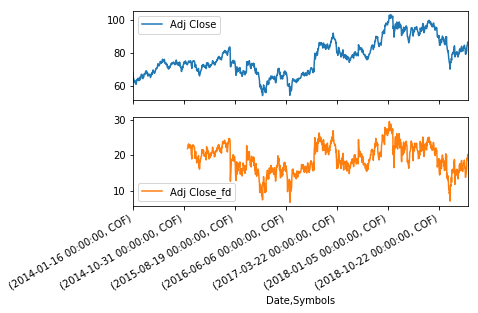

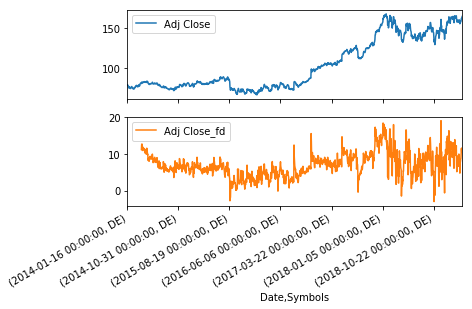

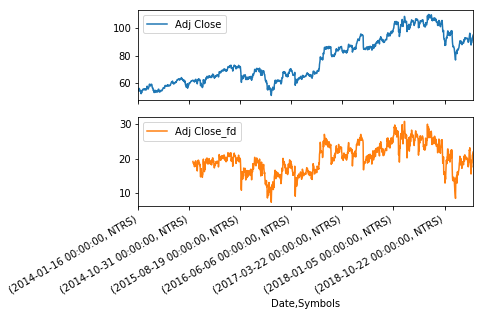

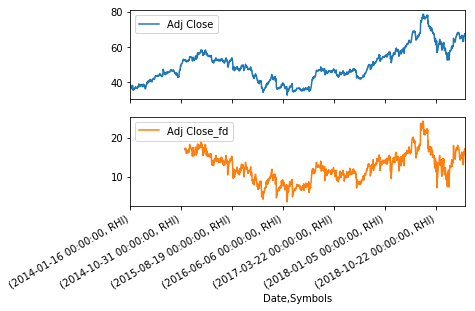

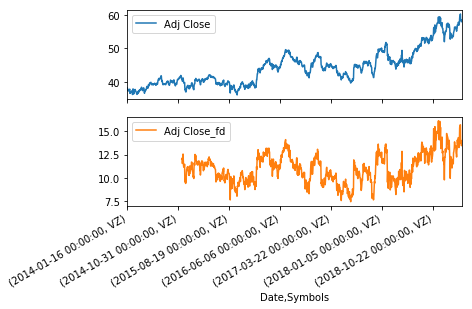

In [0]:
#Test graphics
data_fd.loc[pd.IndexSlice[:, random.sample(list(data_fd.index.levels[1]), 5)],['Adj Close', 'Adj Close_fd']].groupby(level=1).plot(subplots=True)

In [0]:
data_fd.to_pickle("fd_stock_data.pkl")
files.download('fd_stock_data.pkl') 